# Homework 1: Six Degrees of Kevin Bacon

Read [bfs_six_degrees.pdf](bfs_six_degrees.pdf) for the assignment spec. Submit this .ipynb to the professor to demonstrate your solution. This is unofficial and is maintained by a fellow student, Justin, aka the glizzy goblin.

In [98]:
from graph_tools import graph
from collections import deque, defaultdict
from random import sample
from timeit import timeit
from enum import Enum
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [71]:
# Helper Functions
def process_credits_file_to_graph(graph:graph, file_path:str):
    try:
        with  open(file_path, 'r', encoding='utf-8') as list_edges:
            for line in list_edges:
                process_line(graph, line)
    except FileNotFoundError:
        print(f"Error: was not able to find {file_path}")
    except UnicodeDecodeError as e:
        print(f"Encoding error while reading the file: {e}")

def process_line(graph:graph, line:str):
    split_line = line.strip().split()
    if not split_line: return
    
    movie_name, actors = split_line[0], split_line[1:]
    
    for actor_1 in actors:
        co_stars = [actor for actor in actors if actor != actor_1]
        for actor_2 in co_stars:
            graph.Add_und_edge(actor_1, actor_2, movie_name)

In [72]:
small_actor_graph = graph()
small_file_path = "smaller_imdb_cleaned.txt"
process_credits_file_to_graph(small_actor_graph, small_file_path)

In [73]:
large_actor_graph = graph()
large_actor_file = "all_imdb_cleaned.txt"
process_credits_file_to_graph(large_actor_graph, large_actor_file)

In [74]:
def format_output(merged_result:list):
    if not merged_result: return "No path found"
    out=""
    for i in range(len(merged_result)):
        if i % 2 == 1:
            out += f"-({merged_result[i]})-"
            continue
        out += merged_result[i]
    return out

**Vanilla BFS**

In [75]:
class BFS_RETURN(Enum):
    DEFAULT= 0 # return formatted output of vertices and edges
    VERTICES= 1 # return list of vertices
    VERTICES_AND_EDGES= 2 # return list of vertices and edges 
    LEVEL_SET= 3 # returns the level set
    CONNECTIVITY= 4 # return the number of node it pass
    SHORTEST_PATHS = 5 # returns dict of shortest path from start to all vertices
    
    
    

def reconstruct_path(adj, current, graph, out: BFS_RETURN):
        # reconstruct path from start to end given adjacency list        
        total_path = []
        while current in adj and current != None:
            total_path.append(current)
            current = adj[current]
        total_path = total_path[::-1]
        
        if out  == BFS_RETURN.VERTICES: return total_path
        
        movies = [graph.adj_list[total_path[i]][total_path[i + 1]] for i in range(len(total_path) - 1)]
        if out == BFS_RETURN.VERTICES_AND_EDGES: return total_path, movies
           
        # merge results between actor names and movie edges
        merged_result = [item for pair in zip(total_path, movies) for item in pair]
        merged_result.extend(total_path[len(movies):])
        return format_output(merged_result)

def bfs(start:str, end:str, graph:graph, out_type:BFS_RETURN=BFS_RETURN.DEFAULT):
    """
    Perform BFS and return results based on the mode:
    - "shortest_path": Return the shortest path from start to end.
    - "level_set": Return the level sets (vertices grouped by distance).
    - "connectivity": Return True/False if end is reachable from start.
    - "edge_count": Return the total number of edges traversed.
    """
    if start not in graph.vertices:
        return "Not Present" 
    if end not in graph.vertices and (out_type == BFS_RETURN.DEFAULT or out_type == BFS_RETURN.VERTICES  or out_type ==BFS_RETURN.VERTICES_AND_EDGES):
        return "Not Present"  

    queue = deque([start])
    visited = set()
    pred = {actor: None for actor in graph.vertices}
    
    # for tracking shortest paths 
    distance = {v: float('inf') for v in graph.vertices}
    count_paths = {v: 0 for v in graph.vertices}
    
    #for tracking level set
    level_sets = defaultdict(set)
    distance_from_start = {start: 0}
    
    #node count
    count = 0
    
    visited.add(start)
    distance[start] = 0 
    count_paths[start] = 1
    
    
    # while queue is not empty
    while queue:
        # pop from queue
        current = queue.popleft()
        current_level = distance_from_start[current]
        level_sets[current_level].add(current)

        if(current == end and (out_type == BFS_RETURN.DEFAULT or out_type == BFS_RETURN.VERTICES  or out_type ==BFS_RETURN.VERTICES_AND_EDGES)):
            return reconstruct_path(adj=pred, current=current, graph=graph, out=out_type)

        for neighbor in graph.adj_list[current]:    
            if neighbor not in visited:
                visited.add(neighbor)
                pred[neighbor] = current
                # distance[neighbor] = distance[current] + 1
                distance_from_start[neighbor] = current_level + 1 #update distance from start
                count += 1 # update node count
                queue.append(neighbor)
            if distance[neighbor] == distance[current] + 1:
                count_paths[neighbor] += count_paths[current]
            
               
    if out_type == BFS_RETURN.LEVEL_SET: return dict(level_sets)
    if out_type == BFS_RETURN.CONNECTIVITY: return count # number of nodes visited
    if out_type == BFS_RETURN.SHORTEST_PATHS: return count_paths # shortest path for vertcies
    return "Not present"
     

**Bi-Directional BFS**

In [76]:
# Refrenced https://www.geeksforgeeks.org/bidirectional-search/

def reconstruct_bidi_path(start_pred:dict, end_pred:dict, start:str,end:str, mid:str, graph:graph, out: BFS_RETURN=BFS_RETURN.DEFAULT):
    
	total_path = []
	current = mid
	while current in start_pred and current != None:
		total_path.append(current)
		current = start_pred[current]
  
	total_path = total_path[::-1]
	current = end_pred[mid]
 
	while current in end_pred and current != None:
		total_path.append(current)
		current = end_pred[current]
  
	if out == BFS_RETURN.VERTICES: return total_path
 
	movies = [graph.adj_list[total_path[i]][total_path[i + 1]] for i in range(len(total_path) - 1)]
	if out == BFS_RETURN.VERTICES_AND_EDGES: return total_path,movies
	
	# merge results between actor names and movie edges
	merged_result = [item for pair in zip(total_path, movies) for item in pair]
	merged_result.extend(total_path[len(movies):])
	return format_output(merged_result)

def BiDi_BFS(start: str, end: str, graph: graph, out_type:BFS_RETURN=BFS_RETURN.DEFAULT):
	if start not in graph.vertices or end not in graph.vertices:
		return "Not present"
	start_queue = deque([])
	end_queue = deque([])

	# initializes start and end visted nodes as false
	start_visited = {actor: False for actor in graph.vertices}
	end_visited = {actor: False for actor in graph.vertices}

	#initialize start and end adj list
	start_pred = {actor: None for actor in graph.vertices}
	end_pred = {actor: None for actor in graph.vertices}
	
	start_queue.append(start)
	start_visited[start] = True
 
	end_queue.append(end)
	end_visited[end] = True
	
	while len(start_queue) > 0  and len(end_queue) > 0:
		# Forward BFS
		curr_start = start_queue.popleft()
		for neighbor in graph.adj_list[curr_start]:
			if not start_visited[neighbor]:
				start_visited[neighbor] = True
				start_pred[neighbor] = curr_start
				start_queue.append(neighbor)
			if(end_visited[neighbor]): # intersection has been found
				return reconstruct_bidi_path(start_pred=start_pred, end_pred=end_pred, start=start, end=end, mid=neighbor, graph=graph, out=out_type)
			
		# Backward BFS
		curr_end = end_queue.popleft()
		for neighbor in graph.adj_list[curr_end]:
			if not end_visited[neighbor]:
				end_visited[neighbor] = True
				end_pred[neighbor] = curr_end
				end_queue.append(neighbor)
			if(start_visited[neighbor]): # intersection has been found
				return reconstruct_bidi_path(start_pred, end_pred, start, end, neighbor, graph, out_type)
	
	return "No Path Found"

## What You Need to Find

This section outlines the specific questions you need to answer. Ensure each question is addressed in a separate code block, with the output clearly presented as either text or visual plots.



1. **Shortest Paths**: For each credits file, find the shortest paths for all the pairs provided in the example input files. Handle corner cases such as:
   - An actor not being present in the graph.
   - The source and destination actors not being connected.  
   Output appropriate messages for these cases.



In [77]:
input_file = "more-input.txt"
output_file = "more-output.txt"

input_parameters = open(input_file, 'r', encoding='utf-8')
expected_output = open(output_file, 'r', encoding='utf-8')

print("Small Credit Graph\n")
for param in input_parameters:
    striped_param = param.strip().split()
    start, end = striped_param[0], striped_param[1]
    path = bfs(start=start, end=end, graph=small_actor_graph)
    print(f"{path}\n")

input_parameters.close()

Small Credit Graph

Brad_Pitt-(On_Location:_Fight_Club)-Edward_Norton-(The_Making_of_'The_Illusionist')-Jessica_Biel-(JT:_Reflections)-Justin_Timberlake-(Justin_Timberlake:_Justified_-_The_Videos)-Nelly-(Nelly_&_St._Lunatics:_Batter_Up)-Ali-(Khaidi_No._150)-Chiranjeevi-(Sye_Raa_Narasimha_Reddy)-Amitabh_Bachchan

Brad_Pitt-(Troy:_In_the_Thick_of_Battle)-Simon_Crane-(A_World_on_the_'Edge_of_Tomorrow')-Tom_Cruise

Will_Smith-(Club_Oscar)-Robert_De_Niro-(Scorsese's_Goodfellas)-Leonardo_DiCaprio-(Inception)-Ellen_Page

Not Present

Not Present

Marion_Cotillard-(Blood_Ties:_Behind_the_Scenes)-Clive_Owen-(King_Arthur:_A_Roundtable_Discussion)-Antoine_Fuqua-(The_Magnificent_Seven:_Gunslingers)-Ethan_Hawke

Kevin_Bacon-(Sundance_Skippy)-Zooey_Deschanel-(Winter_Passing)-Will_Ferrell-(The_Zoolander_Legacy)-Justin_Bieber

Frank_Sinatra_Jr.-(Do_It_in_the_Dirt)-Suzan_Averitt-(Rebel_Dabble_Babble)-James_Franco-(Love_Conquers_All:_The_Making_of_Tristan_+_Isolde)-Jim_Lemley-(Through_the_Eyes_of_Direct

In [78]:
input_file = "more-input.txt"
output_file = "more-output.txt"

input_parameters = open(input_file, 'r', encoding='utf-8')
expected_output = open(output_file, 'r', encoding='utf-8')

print("Large Credit Graph\n")
for param, out in zip(input_parameters, expected_output):
    striped_param = param.strip().split()
    start, end = striped_param[0], striped_param[1]
    path = bfs(start=start, end=end, graph=large_actor_graph)
    if type(path)== str : print(f"{path}\n")
    else: print(f"{format_output(path)}\n")

input_parameters.close()
expected_output.close()

Large Credit Graph

Brad_Pitt-(The_Audition)-Leonardo_DiCaprio-(Louder_Together)-Amitabh_Bachchan

Brad_Pitt-(Interview_with_the_Vampire:_The_Vampire_Chronicles)-Tom_Cruise

Will_Smith-(Made_in_America)-Whoopi_Goldberg-(Na_Nai'a:_Legend_of_the_Dolphins)-Ellen_Page

Marilyn_Monroe-(How_to_Marry_a_Millionaire)-Lauren_Bacall-(Cameraman:_The_Life_and_Work_of_Jack_Cardiff)-Martin_Scorsese-(Corman's_World:_Exploits_of_a_Hollywood_Rebel)-Quentin_Tarantino

Cassandra_Ciangherotti-(Viaje_redondo)-Teresa_Ruiz-(Prisoners_of_the_Ghostland)-Nicolas_Cage-(Adaptation.)-Meryl_Streep

Marion_Cotillard-(A_Good_Year)-Albert_Finney-(Before_the_Devil_Knows_You're_Dead)-Ethan_Hawke

Kevin_Bacon-(Queens_Logic)-John_Malkovich-(Zoolander_No._2:_Believe_in_Your_Selfie)-Justin_Bieber

Frank_Sinatra_Jr.-(Aru_heishi_no_kake)-Toshirô_Mifune-(Shadow_of_the_Wolf)-Jennifer_Tilly-(Bride_of_Chucky)-Katherine_Heigl

Michael_Cera-(Gloria_Bell)-Julianne_Moore-(Psycho)-Viggo_Mortensen



2. **Interesting Paths**: Identify and include some interesting shortest paths discovered in either credits file.


In [126]:
NUM_OF_ACTORS = 20
sub_set_actors = sample(list(small_actor_graph.vertices), NUM_OF_ACTORS)

mid_index = len(sub_set_actors) // 2  
sub_set_actors_1 = sub_set_actors[:mid_index]
sub_set_actors_2 = sub_set_actors[mid_index:]

In [125]:
for actor_1, actor_2 in zip(sub_set_actors_1, sub_set_actors_2):
    print(f"{actor_1} {actor_2}")
    path = bfs(start=actor_1, end=actor_2, graph=small_actor_graph)
    if type(path)== str : print(f"Small actor graph output: {path}\n")
    else: print(f"Small actor graph output:{format_output(path)}\n")

Lee_Anne_Mitchell Michael_Seitz
Small actor graph output: Lee_Anne_Mitchell-(Staring_at_the_Ceiling)-Robert_Smith-(Seduction_of_Patrick)-Taylor_Mead-(New_York_Agora:_The_Legacy_of_the_60s_Counterculture)-Penny_Arcade-(The_Stolen_Moments_of_September)-Chriss_Anglin-(Sex_Wars)-Gerald_Brodin-(Game_of_Thrones:_Bleed_for_the_Throne)-Derek_Babb-(Bona_Fide_Beauty)-Michael_Seitz

Eric_Lindquist Steven_E._de_Souza
Small actor graph output: Eric_Lindquist-(Dual/Duel)-Jason_Johnson-(Cool_Cat_Finds_a_Gun)-Eric_Roberts-(Geppetto's_Secret)-Rene_Auberjonois-(David_Dukes_Memorial)-Leo_Braudy-(Big_Guns,_Bigger_Heroes:_The_1980's_and_the_Rise_of_the_Action_Film)-Steven_E._de_Souza

Paul_La_Greca Shane_Bailey
Small actor graph output: Paul_La_Greca-(Erotic_Images)-Britt_Ekland-(Satan's_Mistress)-Lana_Wood-(Subconscious_Reality)-Conrad_Brooks-(The_Devil_Ant)-Hillary_Clinton-(Road_to_the_Presidency)-James_Carville-(One_Nice_Thing)-Madeleine_Albright-(American_Umpire)-Shane_Bailey

Larry_Rosenstock Janet_Wo

In [127]:
for actor_1, actor_2 in zip(sub_set_actors_1, sub_set_actors_2):
    print(f"{actor_1} {actor_2}")
    path = bfs(start=actor_1, end=actor_2, graph=large_actor_graph)
    if type(path)== str : print(f"Large actor graph output: {path}\n")
    else: print(f"Large actor graph output:{format_output(path)}\n\n")

Salome_Gasviani Bell_Alvarado
Large actor graph output: Salome_Gasviani-(The_Club_of_Masks)-Bradley_T._Miller-(A_Sandwich,_Divided)-Emily_De_Margheriti-(Social_Security)-Danny_Trejo-(1st_Strike)-Stella_Ademiluyi-(Human_Condition)-Bell_Alvarado

Michele_Joo Eddie_Gates
Large actor graph output: Michele_Joo-(A_Day_in_the_Wife)-Erin_Hill-(The_animal_that_therefore_I_am)-Alexandra-(Hot_Body_Competition:_Babe_of_the_Decade)-Rachel_Sterling-(Big_Freaking_Rat)-Caleb_Thomas-(Worthy_the_movie)-Kenney_Myers-(A_Gift_of_the_Heart)-David_Walterhouse-(Through_You)-Eddie_Gates

Mark_Anthony_Brooks Roxane
Large actor graph output: Mark_Anthony_Brooks-(Sb-1070)-Gwyndolyn_Cruz-(Picture_Perfect)-Gary_Babiarz-(Chuck)-Bill_Oberst_Jr.-(Dismal)-Tim_Morris-(Dark_Forest)-John_Cooper-(Schleuse_17)-Roxane

Jeffrey_Bader Alexandria_Washington
Large actor graph output: Jeffrey_Bader-(Bartender's_Song)-Tony_Devon-(Saddle_Up_with_Dick_Wrangler_&_Injun_Joe)-Mickey_Rooney-(Little_Nemo:_Adventures_in_Slumberland)-Danny

Some interesting short path I have found are the ones for Lillete_Dubey Lia_Chapman having the shortest path with the small dataset. While paths for Marilyn_Monroe to Quentin_Tarantino doesn't exist. Neither does the path for Cassandra_Ciangherotti Meryl_Streep as there is no direct path way for them.

On the other hand for the large data set I notice that the shortest path the path between Brad_Pitt and Tom_Cruise as they are adjacent to each other. As thier are more movies that intersect between more actor a lor mor pathways are shorter.


3. **Path Differences**: Analyze how the shortest paths differ between the same vertex pairs across both credits files. Highlight cases where one file leads to shorter paths. Use random pairs to demonstrate the differences.


Notably some of the shortest path using both credit files vary as when using the all_imbd_cleaned.txt there tend to be two vertices with shorter path in comparison the smaller_imbd_cleaned.txt. As well, that form some vertices pairs they don't exist path between them on the small graph(smaller credit file), but often there is one using the large graph(larger credit file). One Two primary example of this are the path between Brad_Pitt -> Amitabh_Bachchan is eight nodes long on the small graph, but on the larger graph it's three nodes. As well with Marilyn_Monroe and Quentin_Tarantino there exists no path between them on the smaller graph, but there is a path on the larger graph.


4. **Kevin Bacon's Level Sets**: For Kevin Bacon or other notable starting actors, calculate the sizes of the level sets (sets of vertices at distance 1, 2, 3, etc.). Present the results in a plot.


In [81]:
def plot_level_set(level_set: dict, actor_name: str):
    levels = sorted(level_set.keys())
    sizes = [len(level_set[level]) for level in levels]
    
    plt.figure(figsize=(8,6))
    plt.bar(levels, sizes, color="lightgreen")
    plt.xlabel("Distance (Level)")
    plt.ylabel("Number of Actors")
    plt.title(f"Level Set Sizes for {actor_name}")
    plt.xticks(levels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()  

Level Set Graph for Small actor graph


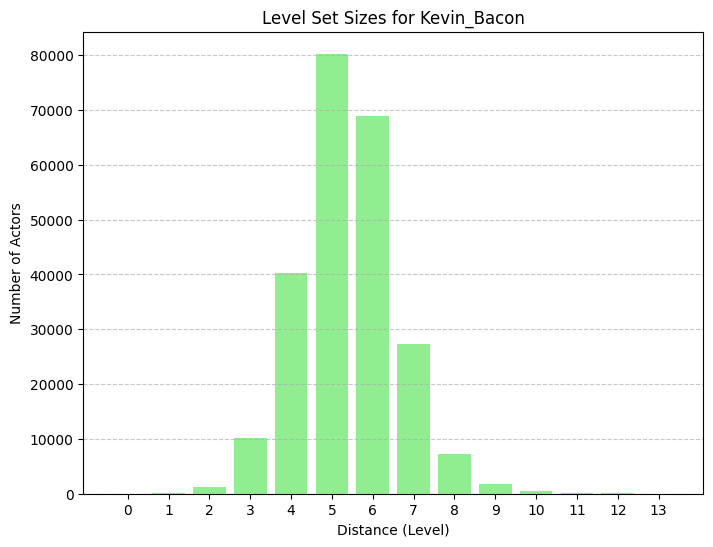



Level Set Graph for Large actor graph


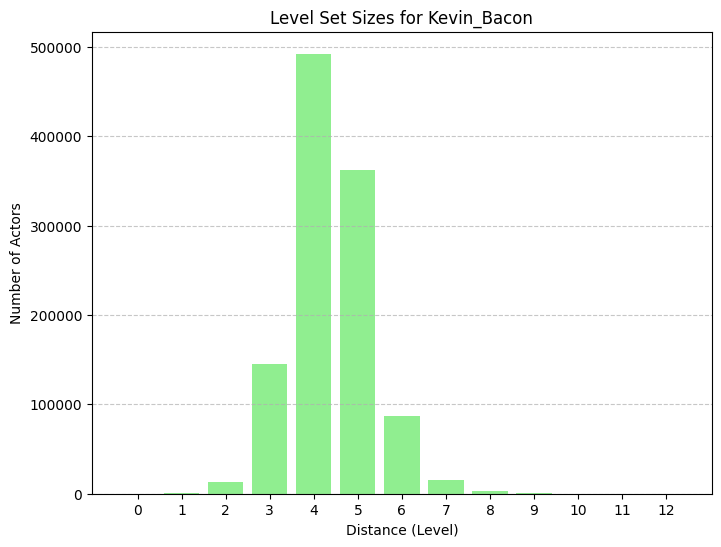

In [82]:
start_actor = 'Kevin_Bacon'
small_level_sets = bfs(start=start_actor, end=None, graph=small_actor_graph, out_type=BFS_RETURN.LEVEL_SET)
print(f"Level Set Graph for Small actor graph")
plot_level_set(small_level_sets, start_actor)
print("\n")
large_level_sets = bfs(start=start_actor, end=None, graph=large_actor_graph, out_type=BFS_RETURN.LEVEL_SET)
print(f"Level Set Graph for Large actor graph")
plot_level_set(large_level_sets, start_actor)


5. **Connected Components**: Determine the sizes of the connected components in each graph.


In [124]:
small_actor_graph_size = small_actor_graph.Size()
large_actor_graph_size = large_actor_graph.Size()
starter_actor = 'Kevin_Bacon' 
small_nodes_connected = bfs(start=starter_actor, end=None, graph=small_actor_graph, out_type=BFS_RETURN.CONNECTIVITY)
large_nodes_connected = bfs(start=starter_actor, end=None, graph=large_actor_graph, out_type=BFS_RETURN.CONNECTIVITY)

print(f"Starting with {starter_actor} there a connectivity size of {small_nodes_connected} in the small actor graph")
print(f"Where Around {small_nodes_connected/small_actor_graph_size[0] :.3f}% are connected on the graph \n")

print(f"Starting with {starter_actor} there a connectivity size of {large_nodes_connected} in the small actor graph")
print(f"Where Around  {large_nodes_connected/large_actor_graph_size[0] :.3f}% are connected on the graph")

Starting with Kevin_Bacon there a connectivity size of 237913 in the small actor graph
Where Around 0.752% are connected on the graph 

Starting with Kevin_Bacon there a connectivity size of 1119310 in the small actor graph
Where Around  0.839% are connected on the graph



6. **Edge Count Comparison**: Compare the number of edges traversed between vanilla BFS and Bidirectional BFS (Bi-BFS) for the pairs in the example input files. Include your own generated examples in this comparison.


In [102]:
def plot_edge_count_comparison(edge_1:dict, edge_2:dict, label1:str, label2:str, title:str):
    all_keys= set(edge_1.keys()).union(edge_2.keys())
    sorted_keys = sorted(all_keys)
    
    values1=[edge_1.get(key, 0) for key in sorted_keys]
    values2=[edge_2.get(key, 0) for key in sorted_keys]
    
    x = np.arange(len(sorted_keys))
    bar_width = .4
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - bar_width / 2, values1, bar_width, label=label1, color='skyblue')
    plt.bar(x + bar_width / 2, values2, bar_width, label=label2, color='salmon')

    # Add labels, title, and legend
    plt.xticks(x, sorted_keys, rotation=45, ha="right")
    plt.xlabel("Node Pairs")
    plt.ylabel("Number of Edges")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()
    return

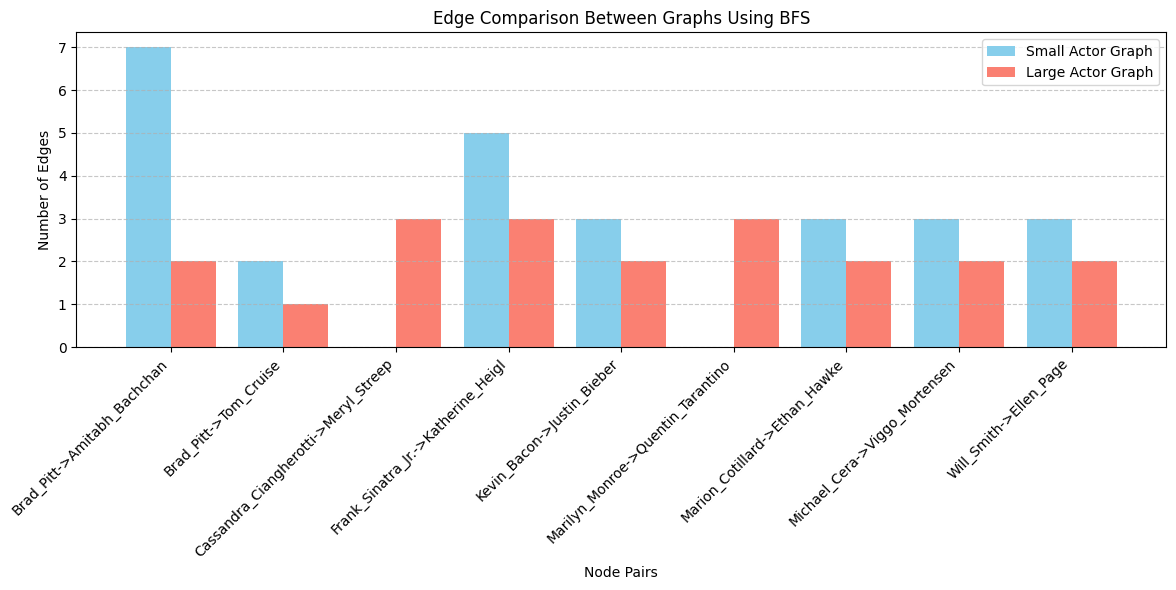

In [104]:
input_parameters = open("more-input.txt", 'r', encoding="utf-8")
small_bfs_edges = dict()
large_bfs_edges = dict()
for param in input_parameters:
    param_strip = param.strip()
    start, end = param_strip.split()
    pair = f"{start}->{end}"
    out = bfs(start=start, end=end, graph=small_actor_graph,out_type=BFS_RETURN.VERTICES_AND_EDGES)
    if type(out) == tuple:
        small_bfs_edges.update({pair:len(out[1])})
    else: 
        small_bfs_edges.update({pair:0})
    
    out = bfs(start=start, end=end, graph=large_actor_graph,out_type=BFS_RETURN.VERTICES_AND_EDGES)
    if type(out) == tuple:
        large_bfs_edges.update({pair:len(out[1])})
    else: 
        large_bfs_edges.update({pair:0})
  
plot_edge_count_comparison(edge_1=small_bfs_edges, edge_2=large_bfs_edges, label1="Small Actor Graph", label2="Large Actor Graph", title="Edge Comparison Between Graphs Using BFS")
input_parameters.close()

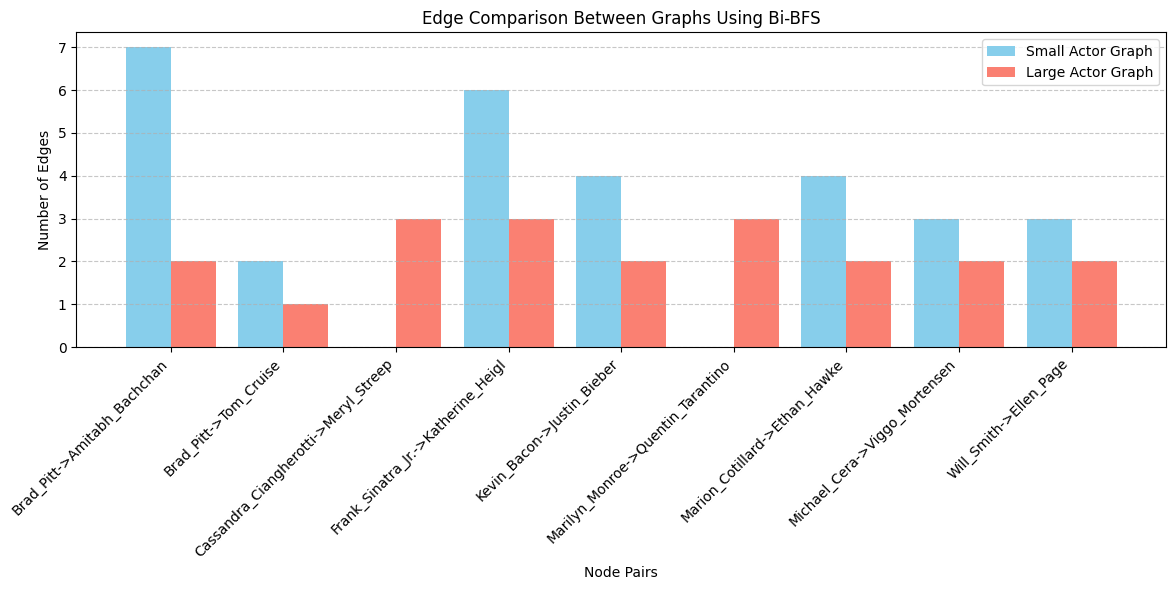

In [105]:
input_parameters = open("more-input.txt", 'r', encoding="utf-8")
small_bi_bfs_edges = dict()
large_bi_bfs_edges = dict()
for param in input_parameters:
    param_strip = param.strip()
    start, end = param_strip.split()
    pair = f"{start}->{end}"
    out = BiDi_BFS(start=start, end=end, graph=small_actor_graph,out_type=BFS_RETURN.VERTICES_AND_EDGES)
    if type(out) == tuple:
        small_bi_bfs_edges.update({pair:len(out[1])})
    else: 
        small_bi_bfs_edges.update({pair:0})
    
    out = BiDi_BFS(start=start, end=end, graph=large_actor_graph,out_type=BFS_RETURN.VERTICES_AND_EDGES)
    if type(out) == tuple:
        large_bi_bfs_edges.update({pair:len(out[1])})
    else: 
        large_bi_bfs_edges.update({pair:0})
  
plot_edge_count_comparison(edge_1=small_bi_bfs_edges, edge_2=large_bi_bfs_edges, label1="Small Actor Graph", label2="Large Actor Graph", title="Edge Comparison Between Graphs Using Bi-BFS")
input_parameters.close()


7. **Wall-Clock Time**: Measure and compare the actual running times of BFS and Bi-BFS using the `timeit` module in Python. Provide wall-clock time data for the pairs in the example input files, as well as your own examples.


In [112]:
def compare_algorithm_time(start, end, graph):
	bfs_time = timeit(lambda : bfs(start=start, end=end, graph=graph, out_type=BFS_RETURN.DEFAULT), number=1)
	bi_bfs_time = timeit(lambda : BiDi_BFS(start=start, end=end, graph=graph, out_type=BFS_RETURN.DEFAULT), number=1)
	return bfs_time, bi_bfs_time

def collect_runtime_data(input_parameters:str, graph:graph):
	bfs_times = []
	bi_bfs_times = []
	pairs = []
	for param in input_parameters:
		striped_param = param.strip().split()
		start, end = striped_param[0], striped_param[1]
		bfs_time, bi_bfs_time = compare_algorithm_time(start, end, graph)

		bfs_times.append(bfs_time)
		bi_bfs_times.append(bi_bfs_time)
		pairs.append(f"{start}->{end}")

	return bfs_times, bi_bfs_times, pairs

def plot_runtime_comparison(bfs_times, bi_bfs_times, pairs, graph_name):
    plt.figure(figsize=(12, 6))
    x = range(len(pairs))

    bar_width = 0.4  # Width of the bars
    plt.bar([i - bar_width / 2 for i in x], bfs_times, bar_width, label="BFS", color='skyblue')
    plt.bar([i + bar_width / 2 for i in x], bi_bfs_times, bar_width, label="Bi-BFS", color='darkorange')

    plt.xticks(x, pairs, rotation=45, ha="right")
    plt.xlabel("Actor Pairs")
    plt.ylabel("Runtime (seconds)")
    plt.title(f"Runtime Comparison of BFS vs Bi-BFS ({graph_name})")
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Runtime Comparison using Small Actor Graph


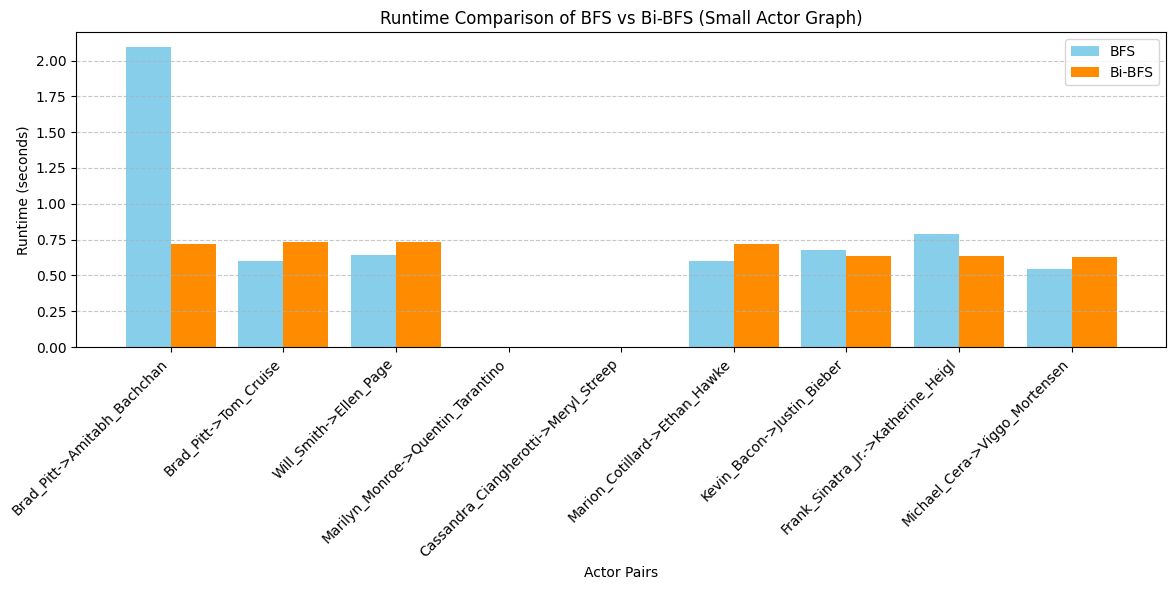

In [113]:
print("Runtime Comparison using Small Actor Graph")
input_parameters = open("more-input.txt", 'r', encoding='utf-8')  
bfs_times_small, bi_bfs_times_small, pairs_small = collect_runtime_data(input_parameters, small_actor_graph)
plot_runtime_comparison(bfs_times_small, bi_bfs_times_small, pairs_small, "Small Actor Graph")
input_parameters.close()

Runtime Comparison using Large Actor Graph


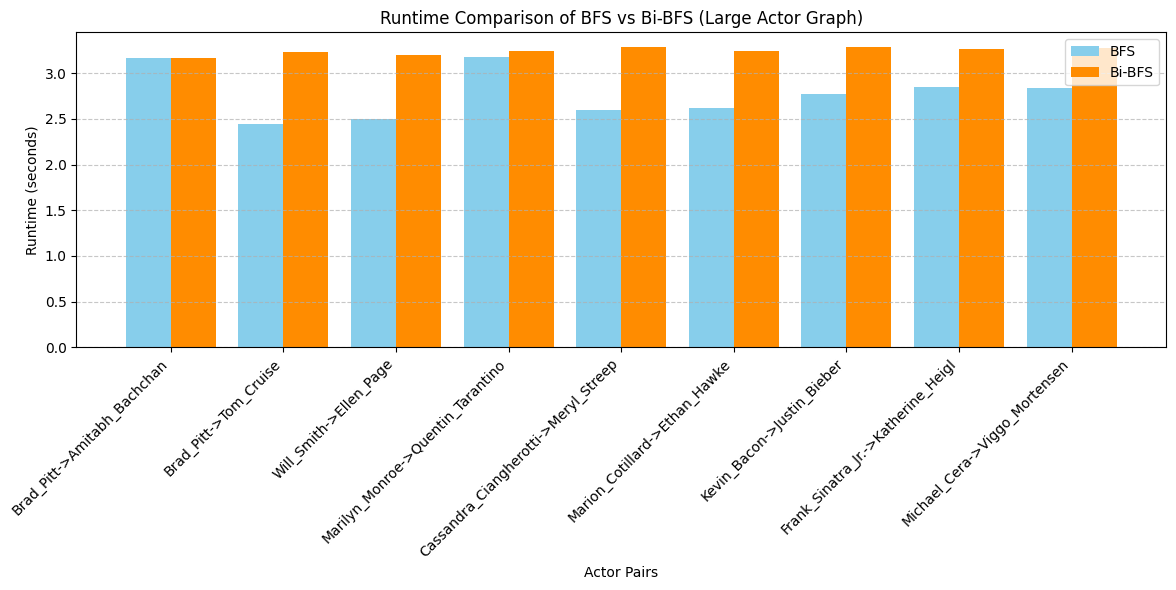

In [114]:
print("Runtime Comparison using Large Actor Graph")
input_parameters = open("more-input.txt", 'r', encoding='utf-8')  
bfs_times_large, bi_bfs_times_large, pairs_large = collect_runtime_data(input_parameters, large_actor_graph)
plot_runtime_comparison(bfs_times_large, bi_bfs_times_large, pairs_large, "Large Actor Graph")
input_parameters.close()